In [1]:
import pandas as pd
import gzip
import json
import pickle
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [3]:
df = getDF('apsd/Cell_Phones_and_Accessories_5.json.gz')

In [4]:
df.shape

(1128437, 12)

In [5]:
df1 = df[['asin', 'reviewText']]

In [6]:
df1

,asin,reviewText
0,7508492919,Looks even better in person. Be careful to not...
1,7508492919,When you don't want to spend a whole lot of ca...
2,7508492919,"so the case came on time, i love the design. I..."
3,7508492919,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...
4,7508492919,"I liked it because it was cute, but the studs ..."
...,...,...
1128432,B01HJC7N4C,Good for viewing. But doesn't have a button or...
1128433,B01HJC7N4C,I was given the Rockrok 3D VR Glasses Headset ...
1128434,B01HJC7N4C,Super Fun! The RockRoc 3d vr headset is waaaay...
1128435,B01HJC7N4C,Love it!\n\nI've had other VR glasses which al...


In [7]:
sentences = list(df1['reviewText'].dropna().values)

In [9]:
len(sentences)

1127672

In [8]:
len(pd.unique(df1['asin']))

48186

In [10]:
# tokenization
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [42]:
# Remove stop words
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [43]:
for s in sentences[:5]:
    print(s)
    words = s.split()
    words = [w for w in words if not w in stop_words]
    s = ' '.join(words)
    print(s)
    print('')

Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.
Looks even better person. Be careful drop phone often rhinestones fall (duh). More decorative case protective, I say fits perfectly securely phone. Overall, pleased purchase.

When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!
When want spend whole lot cash want great deal...this shop buy from!

so the case came on time, i love the design. I'm actually missing 2 studs but nothing too noticeable the studding is almost a bit sloppy around the bow, but once again not too noticeable. I haven't put in my phone yet so this is just what I've notice so far
case came time, love design. I'm actually missing 2 studs nothing noticeable studding almost bit sloppy around bow, notic

In [40]:
for s in sentences[:5]:
    print(s)
    s_tok = tokenizer.tokenize(s)
    print(s_tok)
    print('')

Looks even better in person. Be careful to not drop your phone so often because the rhinestones will fall off (duh). More of a decorative case than it is protective, but I will say that it fits perfectly and securely on my phone. Overall, very pleased with this purchase.
['looks', 'even', 'better', 'in', 'person', '.', 'be', 'careful', 'to', 'not', 'drop', 'your', 'phone', 'so', 'often', 'because', 'the', 'rhine', '##stones', 'will', 'fall', 'off', '(', 'du', '##h', ')', '.', 'more', 'of', 'a', 'decorative', 'case', 'than', 'it', 'is', 'protective', ',', 'but', 'i', 'will', 'say', 'that', 'it', 'fits', 'perfectly', 'and', 'securely', 'on', 'my', 'phone', '.', 'overall', ',', 'very', 'pleased', 'with', 'this', 'purchase', '.']

When you don't want to spend a whole lot of cash but want a great deal...this is the shop to buy from!
['when', 'you', 'don', "'", 't', 'want', 'to', 'spend', 'a', 'whole', 'lot', 'of', 'cash', 'but', 'want', 'a', 'great', 'deal', '.', '.', '.', 'this', 'is', 'th

In [18]:
stok_len = []
for s in tqdm(sentences):
    try:
        s_tok = tokenizer.tokenize(s)
        stok_len.append(len(s_tok))
    except:
        print(s)
print(np.mean(stok_len))

100%|██████████| 1127672/1127672 [13:57<00:00, 1347.13it/s]

62.451375932008595


<AxesSubplot:ylabel='Count'>

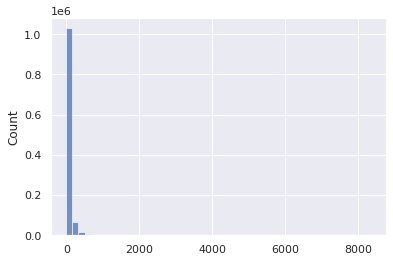

In [32]:
# plot a beautiful and well visualized histogram of the tokenized sentence lengths
import seaborn as sns
sns.set_theme()
sns.histplot(stok_len, bins=50)

### Get all tokens for each item in the dataset

In [9]:
df2 = df1.copy()
df2 = df2.dropna()
df2 = df2.groupby('asin')['reviewText'].apply(list).reset_index()

In [12]:
data = []
for _,row in tqdm(df2.iterrows(), total=df2.shape[0]):
    asin = row['asin']
    reviews = row['reviewText']
    reviews = ' '.join(reviews)
    tokens = tokenizer.tokenize(reviews)
    tokens = list(set(tokens))
    df3 = data.append({'asin': asin, 'tokens': tokens})
df3 = pd.DataFrame(data)

100%|██████████| 48186/48186 [07:46<00:00, 103.28it/s]


In [13]:
df3['num_tokens'] = df3['tokens'].apply(len)

In [14]:
# df3.to_parquet('data/item_tokens.parquet')

In [55]:
def transform_reviews(reviews):
    reviews = ' '.join(reviews)
    tokens = tokenizer.tokenize(reviews)
    tokens = list(set(tokens))
    return tokens

In [ ]:
df3 = df2[['asin']]
df3['tokens'] = df2['reviewText'].apply(transform_reviews)

<AxesSubplot:xlabel='num_tokens', ylabel='Count'>

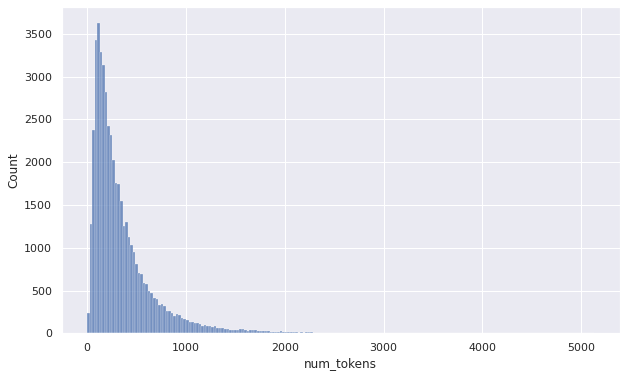

In [82]:
plt.figure(figsize=(10, 6))
sns.histplot(df3['num_tokens'], bins=200)

In [13]:
df3 = pd.read_parquet('data/item_tokens.parquet')

In [14]:
df3

,asin,tokens,num_tokens
0,7508492919,"[give, clear, bathroom, floor, slightly, know,...",608
1,7532385086,"[recommend, ,, i, $, cool, all, their, gave, l...",247
2,7887421268,"[give, recommend, ,, peeling, does, i, because...",232
3,8199900164,"[rate, ,, acceptable, own, on, stopped, a, get...",67
4,8288853439,"[give, recommend, ,, minutes, does, i, timed, ...",271
...,...,...,...
48181,B01HJBS5C2,"[minutes, open, easy, texture, also, hasn, up,...",320
48182,B01HJC7N4C,"[give, minutes, sample, 30, open, ##load, easy...",467
48183,B01HJCN1UC,"[paired, know, easy, seller, most, also, your,...",351
48184,B01HJCN55I,"[give, recommend, ,, using, does, i, because, ...",188


In [17]:
df3['num_tokens'].describe(percentiles=[0.25,0.5,0.75,0.8,0.9,0.95,1.0])

count    48186.000000
mean       360.160711
std        362.503649
min          1.000000
25%        138.000000
50%        248.000000
75%        448.000000
80%        516.000000
90%        761.000000
95%       1034.000000
100%      5131.000000
max       5131.000000
Name: num_tokens, dtype: float64

In [18]:
token2count = {}
for tokens in tqdm(list(df3['tokens'])):
    for t in tokens:
        if t in token2count:
            token2count[t] += 1
        else:
            token2count[t] = 1

100%|██████████| 48186/48186 [00:03<00:00, 13790.39it/s]


In [21]:
with open('data/item_token2count.json', 'w') as f:
    json.dump(token2count, f)

In [30]:
len(token2count)

23063

In [26]:
count2token = {}
for t,c in token2count.items():
    if c in count2token:
        count2token[c].append(t)
    else:
        count2token[c] = [t]

In [27]:
count2token = {item[0]: item[1] for item in sorted(count2token.items(), reverse=True)}


In [29]:
with open('data/item_count2tokens.json', 'w') as f:
    json.dump(count2token, f)

In [28]:
count2token

{48090: ['.'],
 47626: ['the'],
 47597: ['it'],
 47383: ['and'],
 47202: ['i'],
 46718: ['a'],
 46557: [','],
 46311: ['to'],
 45802: ['this'],
 45610: ['my'],
 45598: ['for'],
 45587: ['is'],
 45360: ["'"],
 43670: ['but'],
 43256: ['of'],
 42956: ['on'],
 42603: ['not'],
 42288: ['phone'],
 42276: ['in'],
 42194: ['great'],
 41918: ['with'],
 41866: ['t'],
 41596: ['that'],
 41217: ['very'],
 40750: ['!'],
 40464: ['good'],
 40343: ['was'],
 40079: ['s'],
 39853: ['have'],
 39392: ['so'],
 39023: ['as'],
 38862: ['you'],
 38029: ['like'],
 36986: ['one'],
 36144: ['well'],
 35922: ['just'],
 35723: ['case'],
 35038: ['product'],
 34818: ['be'],
 34337: ['if'],
 34215: ['would'],
 34156: ['all'],
 33707: ['##s'],
 33295: ['at'],
 33193: ['can'],
 33157: ['are'],
 32829: ['when'],
 32652: ['will'],
 32579: ['nice'],
 32403: ['from'],
 32366: ['love'],
 32301: ['or'],
 32165: ['had'],
 32153: ['out'],
 31867: ['has'],
 31813: ['no'],
 31689: ['use'],
 31081: ['get'],
 30772: ['really'],

In [101]:
max(token2count.values())

48090

In [102]:
min(token2count.values())

1

<AxesSubplot:ylabel='Count'>

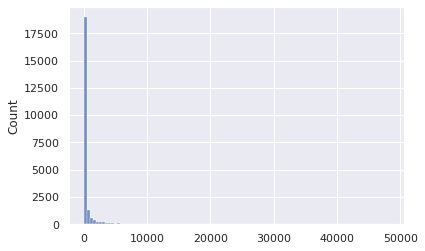

In [107]:
sns.histplot(list(token2count.values()), bins=100)